In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [332]:
#Importing Dataset
df = pd.read_csv("transaction_dataset.csv", index_col=0)

In [333]:
# print(*sorted(df.columns.tolist()), sep='\n')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  
 7   Received Tnx                                          9841 non-null   int64  
 8   Number of Created Contracts                           9841

In [334]:
# Omit first two columns (Index, Adress)
df = df.iloc[:,2:]

# df.info()

Esta no la sabía:

In [335]:
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
df[categories].head()

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,None,XENON
3,Raiden,XENON
4,StatusNetwork,EOS


Esto por qué? Es contradictorio haberlas convertido si las iba a tirar

In [336]:
# Drop the two categorical features
categories = df.select_dtypes('O').columns.astype('category')
df.drop(df[categories], axis=1, inplace=True)

# df.info()

In [337]:
# Inspect features variance
numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].var()

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

Esta no la sabía:

### Ojo:

Variance is range-dependent, therefore we need to do normalization before applying this technique.

Sin embargo, ninguna transformación va a cambiar el hecho de que una varianza sea 0, así que si lo que quiero hacer es tirar las que tienen varianza nula (no muy chica) entonces no va a haber problema

In [338]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                    

0    7662
1    2179
Name: FLAG, dtype: int64


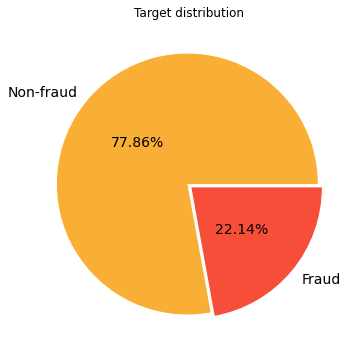

In [339]:
# Inspect target distribution
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[6,6])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

Esto está bueno:

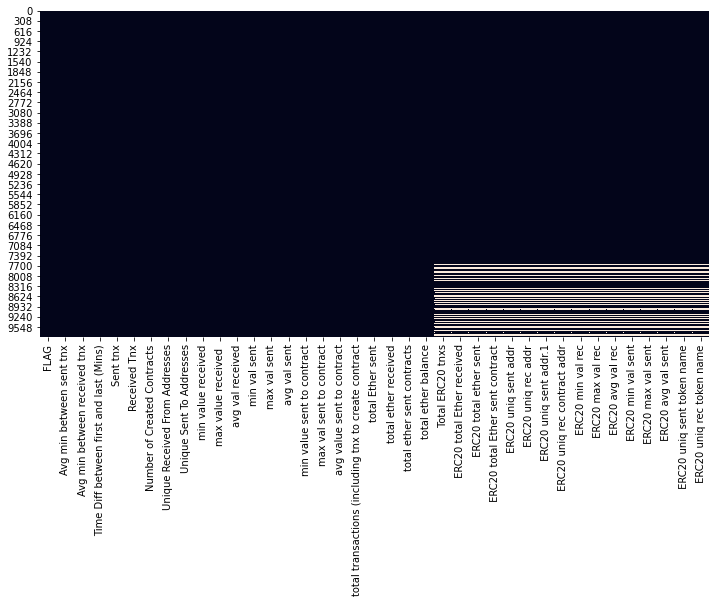

In [340]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

Esto se puede hacer de otras maneras:

In [341]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

In [342]:
# Recheck the Correlation matrix
# corr = df.corr()

# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)]=True
# with sns.axes_style('white'):
#     fig, ax = plt.subplots(figsize=(18,10))
#     sns.heatmap(corr,  mask=mask, annot=False, center=0, linewidths=0.1, square=True)

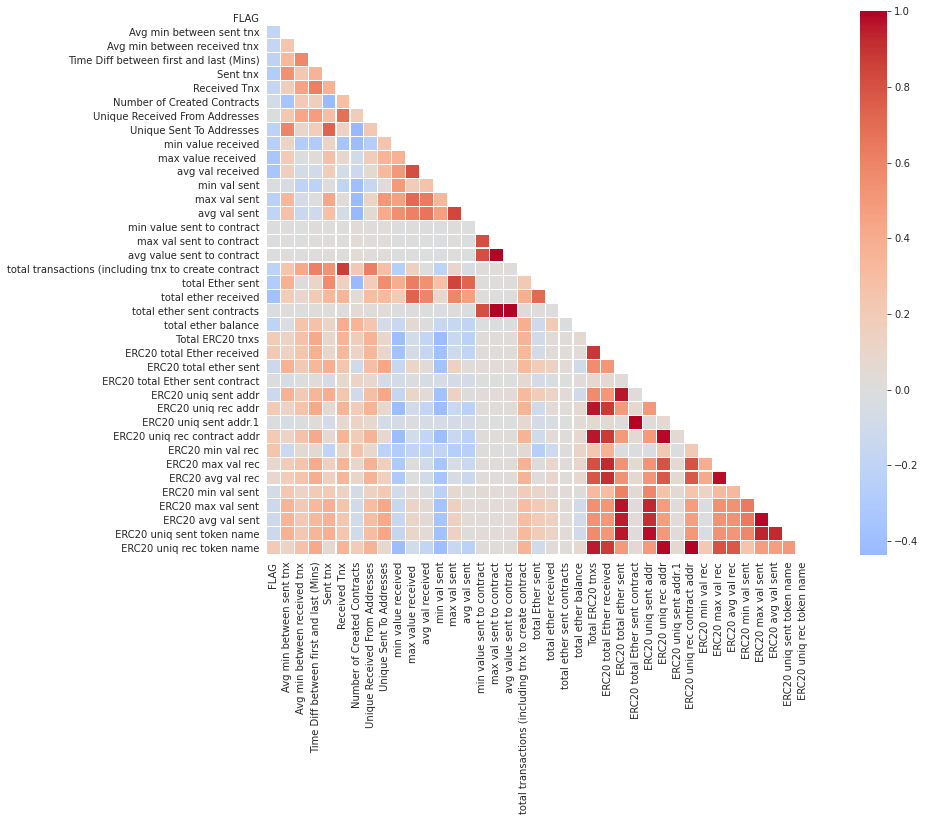

In [343]:
# calculate correlation matrix
## using non-parametric test of correlation (kendall), since some features are binary
# corrs = df.select_dtypes(include=np.number).corr(method = 'kendall')
corr = df.corr(method = 'kendall')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, center=0, cmap='coolwarm', linewidths=0.1, square=True)

Esto no sé cómo se justifica:

In [344]:
# drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
#         ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
#         ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
#         'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
# df.drop(drop, axis=1, inplace=True)

In [345]:
# mi versión, a ojo pero sin mandar fruta

drop = ['total ether sent contracts',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 avg val sent',
        ' ERC20 uniq sent token name']
df.drop(drop, axis=1, inplace=True)

In [346]:
# veo cómo quedó después de tirar

# corr = df.corr(method = 'kendall')

# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)]=True
# with sns.axes_style('white'):
#     fig, ax = plt.subplots(figsize=(18,10))
#     sns.heatmap(corr,  mask=mask, annot=False, center=0, cmap='coolwarm', linewidths=0.1, square=True)

In [347]:
# Some features present a small distribution
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
0.00    9839
0.02       1
0.01       1
Name: min value sent to contract, dtype: int64
The column max val sent to contract has the following distribution: 
0.000000    9838
0.020000       1
0.010000       1
0.046029       1
Name: max val sent to contract, dtype: int64
The column avg value sent to contract has the following distribution: 
0.000000    9838
0.023014       1
0.020000       1
0.010000       1
Name: avg value sent to contract, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
0.0    9813
1.0      26
2.0       1
3.0       1
Name:  ERC20 uniq sent addr.1, dtype: int64


It can be observed that the values of these two variables are mosty 0s. Thus, both features will be discarded since they will not be helpful for our model

In [348]:
# HACER ESTO CODEADO, NO A MANO

# drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']

# sin tirar nada a mano:
# drops = ['min value sent to contract', 'max val sent to contract', 'avg value sent to contract', 'total ether sent contracts', ' ERC20 uniq sent addr.1']

drops = ['min value sent to contract', 'max val sent to contract', 'avg value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)
df.head()

(9841, 30)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 min val sent,ERC20 max val sent,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,...,3.558854e+07,3.560317e+07,0.0,30.0,54.0,58.0,0.0,0.000000,1.683100e+07,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,...,4.034283e+02,2.260809e+00,0.0,1.0,5.0,7.0,0.0,2.260809,2.260809e+00,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,...,5.215121e+02,0.000000e+00,0.0,0.0,7.0,8.0,0.0,0.000000,0.000000e+00,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,...,1.711105e+04,1.141223e+04,0.0,2.0,11.0,11.0,0.0,100.000000,9.029231e+03,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,...,1.628297e+05,1.235399e+05,0.0,4.0,23.0,27.0,0.0,0.000000,4.500000e+04,27.0


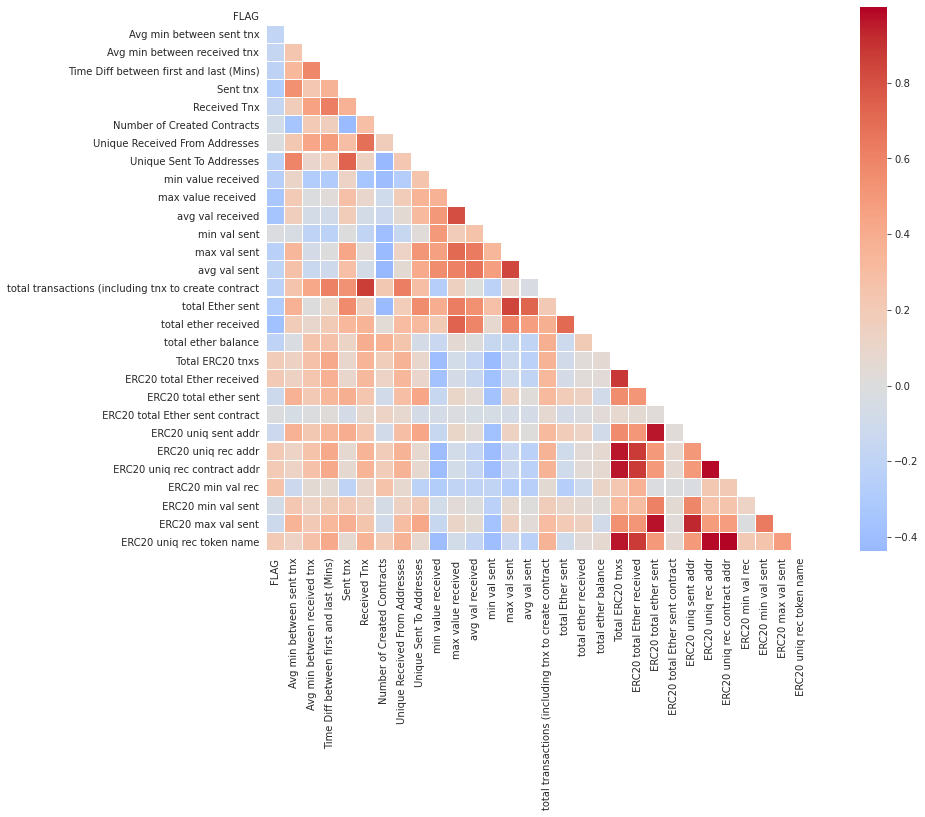

In [349]:
# cómo queda después de tirar

corr = df.corr(method = 'kendall')

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, center=0, cmap='coolwarm', linewidths=0.1, square=True)

In [350]:
# separo en X e y:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 29) (9841,)


In [351]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 29) (7872,)
(1969, 29) (1969,)


Y esto??

Standardization is beneficial in many cases. It improves the numerical stability of the model and often reduces training time. However, standardization isn’t always great. It can harm the performance of distance-based clustering algorithms by assuming equal importance of features. If there are inherent importance differences between features, it’s generally not a good idea to do standardization

In [352]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [353]:
# pruebo hacer scaling en lugar de normalization porque me dice que lo necesita para que converja la regresión

# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler().fit(X_train)

# X_train_scaled = pd.DataFrame(scaler.transform(X_train))
# X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [354]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df.head()

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 min val sent,ERC20 max val sent,ERC20 uniq rec token name
0,1.294061,1.151313,1.393751,1.591951,1.017881,-0.401539,1.268692,1.873167,-0.718499,1.170696,...,1.815951,2.508169,-0.038483,2.398649,1.783833,1.829828,-0.496299,-0.269174,2.503682,1.831406
1,-1.096066,-1.184221,-1.638410,-1.391726,-1.785005,-0.401539,-2.250405,-1.490712,-0.779765,-1.407378,...,-0.746114,-0.410600,-0.038483,-0.437145,0.228526,0.224883,-0.496299,-0.269174,-0.410825,0.226082
2,-0.006354,0.213137,1.103220,1.970707,1.876994,-0.401539,0.164531,-0.343138,-0.756778,0.613575,...,-0.746114,-0.410600,-0.038483,-0.437145,-0.995095,-0.993733,-0.496299,-0.269174,-0.410825,-0.994019
3,-1.096066,1.220438,0.195684,-1.391726,-0.618856,2.490307,-0.213813,-1.490712,-0.779765,-0.871196,...,-0.746114,-0.410600,-0.038483,-0.437145,-0.995095,-0.993733,-0.496299,-0.269174,-0.410825,-0.994019
4,0.628503,-1.121221,-0.904665,-0.206187,-0.618856,-0.401539,-0.213813,0.168964,1.753278,0.889875,...,-0.746114,-0.410600,-0.038483,-0.437145,-0.995095,-0.993733,-0.496299,-0.269174,-0.410825,-0.994019


Oversampling using SMOTE:

In [355]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

# usando scaling en lugar de normalization
# print(f'Shape of the training before SMOTE: {X_train_scaled.shape, y_train.shape}')

# x_tr_resample, y_tr_resample = oversample.fit_resample(X_train_scaled, y_train)
# print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7872, 29), (7872,))
Shape of the training after SMOTE: ((12230, 29), (12230,))


Logistic Regression:

In [356]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

# usando scaling en lugar de normalization
# LR = LogisticRegression(random_state=42)
# LR.fit(x_tr_resample, y_tr_resample)

# # Transform test features
# # esto es como el X_test_scaled que calculé antes, que él recién lo calculaba ahora
# # norm_test_f = norm.transform(X_test)

# preds = LR.predict(X_test_scaled)

/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1547
           1       0.82      0.94      0.88       422

    accuracy                           0.94      1969
   macro avg       0.90      0.94      0.92      1969
weighted avg       0.95      0.94      0.94      1969

[[1459   88]
 [  24  398]]


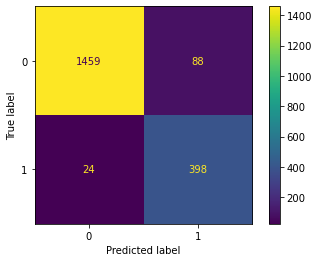

In [357]:
# print(classification_report(y_test, preds))
# print(confusion_matrix(y_test, preds))
# _ = plot_confusion_matrix(LR, norm_test_f, y_test)

# usando scaling en lugar de normalization

print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
_ = plot_confusion_matrix(LR, norm_test_f, y_test)

In [358]:
# def draw_cm(y_test, y_pred):
#   cm = confusion_matrix(y_test, y_pred)
#   cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#   df_cm = pd.DataFrame(cm_norm)
#   plt.figure(figsize = (6,4))
#   sns.heatmap(df_cm, annot=True, cmap="Blues")
#   plt.xlabel("Predicted class")
#   plt.ylabel("True class")
#   plt.show()
#   print("Accuracy: {0:.3f}".format(accuracy_score(y_test, y_pred)))
#   print("Precision: {0:.3f}".format(precision_score(y_test, y_pred)))
#   print("Recall: {0:.3f}".format(recall_score(y_test, y_pred)))
#   print("F1 Score: {0:.3f}".format(f1_score(y_test, y_pred)))

In [359]:
# draw_cm(y_test, preds)